## **Importing libraries and datasets**

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [7]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [8]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [9]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [10]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [14]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()}) # Monetary Value

df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

In [15]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


## **Calculating response rate**

In [16]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


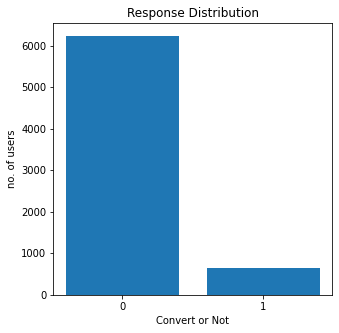

In [17]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [19]:
## merging two data sets

df_modeling = pd.merge(df_response,df_rfm)
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


Text(0.5, 1.05, 'Pearson correlation of Features')

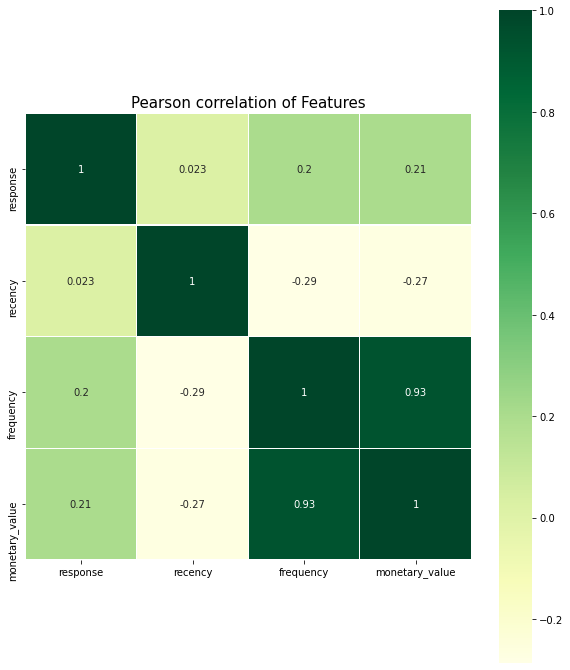

In [66]:
%matplotlib inline
corr = df_modeling.corr()

f, ax = plt.subplots(figsize=(10, 12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, cmap="YlGn", square=True, ax=ax, annot=True, linewidth=0.1)

plt.title("Pearson correlation of Features", y=1.05, size=15)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

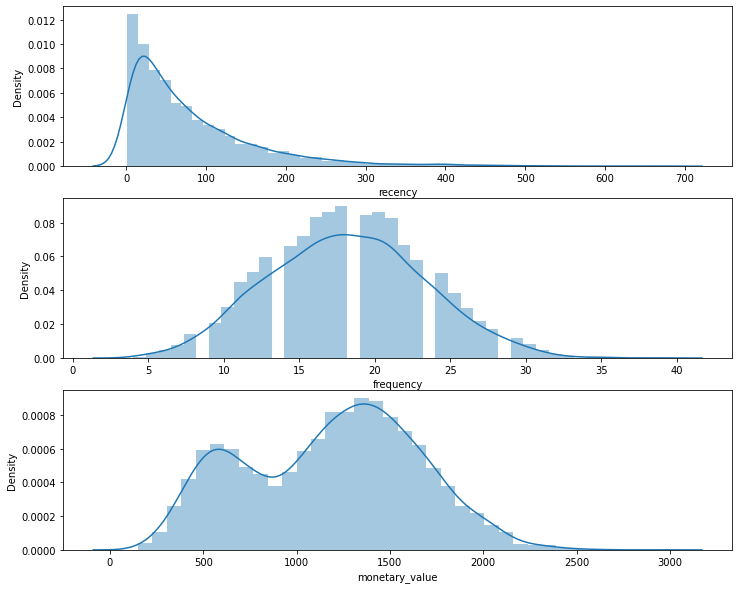

In [112]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df_modeling['recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df_modeling['frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df_modeling['monetary_value'])
# Show the plot
plt.show()

In [113]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(df_modeling['recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(df_modeling['frequency'], q=4, labels=f_labels)
# Create new columns R and F 
df_modeling = df_modeling.assign(R = r_groups.values, F = f_groups.values)
df_modeling.head()


,customer_id,response,recency,frequency,monetary_value,R,F
0,CS1112,0,62.0,15,1012,2,2
1,CS1113,0,36.0,20,1490,3,3
2,CS1114,1,33.0,19,1432,3,3
3,CS1115,1,12.0,22,1659,4,3
4,CS1116,1,204.0,13,857,1,1


In [117]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(df_modeling['monetary_value'], q=4, labels=m_labels)
# Create new column M
df_modeling = df_modeling.assign(M = m_groups.values)
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value,R,F,M
0,CS1112,0,62.0,15,1012,2,2,2
1,CS1113,0,36.0,20,1490,3,3,3
2,CS1114,1,33.0,19,1432,3,3,3
3,CS1115,1,12.0,22,1659,4,3,4
4,CS1116,1,204.0,13,857,1,1,2


In [119]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
df_modeling['RFM_Segment_Concat'] = df_modeling.apply(join_rfm, axis=1)
rfm = df_modeling
rfm.head()

,customer_id,response,recency,frequency,monetary_value,R,F,M,RFM_Segment_Concat
0,CS1112,0,62.0,15,1012,2,2,2,222
1,CS1113,0,36.0,20,1490,3,3,3,333
2,CS1114,1,33.0,19,1432,3,3,3,333
3,CS1115,1,12.0,22,1659,4,3,4,434
4,CS1116,1,204.0,13,857,1,1,2,112


In [120]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

48


In [121]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

0     6
1     9
2     9
3    11
4     4
Name: RFM_Score, dtype: int64


In [137]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,customer_id,response,recency,frequency,monetary_value,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
0,CS1112,0,62.0,15,1012,2,2,2,222,6,Potential
1,CS1113,0,36.0,20,1490,3,3,3,333,9,Can't Loose Them
2,CS1114,1,33.0,19,1432,3,3,3,333,9,Can't Loose Them
3,CS1115,1,12.0,22,1659,4,3,4,434,11,Can't Loose Them
4,CS1116,1,204.0,13,857,1,1,2,112,4,Needs Attention


In [146]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   recency frequency monetary_value      
                      mean      mean           mean count
RFM_Level                                                
Can't Loose Them      41.3      23.2         1625.4  2533
Champions             57.1      18.8         1264.1   844
Loyal                 81.0      17.5         1136.0   850
Needs Attention      131.4      12.7          649.5   548
Potential             70.0      15.0          893.7   827
Promising            109.2      14.1          818.9   737
Require Activation   231.0      10.8          502.9   545


In [148]:
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
0,CS1112,0,62.0,15,1012,2,2,2,222,6,Potential
1,CS1113,0,36.0,20,1490,3,3,3,333,9,Can't Loose Them
2,CS1114,1,33.0,19,1432,3,3,3,333,9,Can't Loose Them
3,CS1115,1,12.0,22,1659,4,3,4,434,11,Can't Loose Them
4,CS1116,1,204.0,13,857,1,1,2,112,4,Needs Attention


Text(0.5, 1.05, 'Pearson correlation of Features')

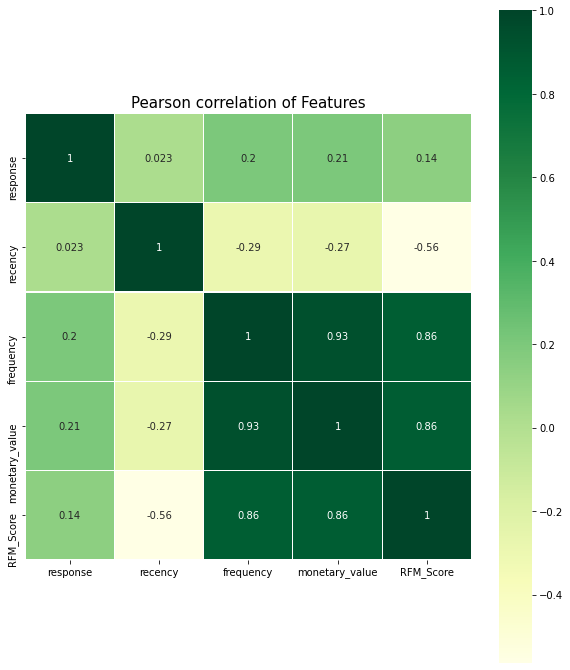

In [151]:
%matplotlib inline
corr = df_modeling.corr()

f, ax = plt.subplots(figsize=(10, 12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, cmap="YlGn", square=True, ax=ax, annot=True, linewidth=0.1)

plt.title("Pearson correlation of Features", y=1.05, size=15)

## **Creating train and test dataset**

In [204]:
## spliting dataframe into X and y
dfpontential= df_modeling[df_modeling['RFM_Level']=='Champions']
##dfpontential.head()
X = dfpontential.drop(columns=['response','customer_id','frequency','R','F','M','RFM_Segment_Concat','RFM_Score','RFM_Level'])
y = dfpontential['response']
X.head()

,recency,monetary_value
6,3.0,1011
7,12.0,1158
11,110.0,1331
25,56.0,1380
30,162.0,1847


In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (590, 2)
Number transactions y_train dataset:  (590,)
Number transactions X_test dataset:  (254, 2)
Number transactions y_test dataset:  (254,)


Text(0.5, 1.0, 'Imbalanced Data')

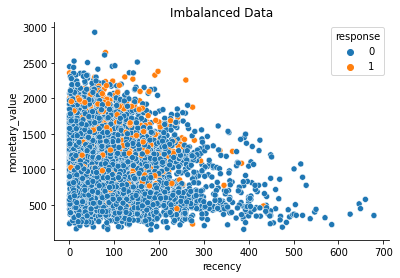

In [206]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

## **Fixing imbalanced with Undersampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

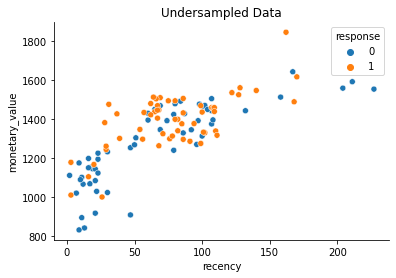

In [207]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency','monetary_value', 'response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

## **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

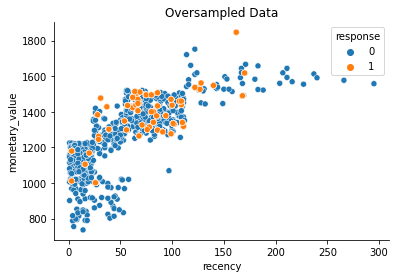

In [208]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'monetary_value', 'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

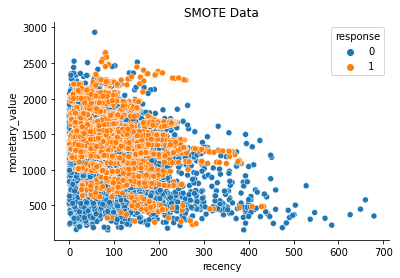

In [86]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'monetary_value', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

## **Logistic Regression Model**

In [209]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.74      0.49      0.59        57
           1       0.62      0.82      0.71        57

    accuracy                           0.66       114
   macro avg       0.68      0.66      0.65       114
weighted avg       0.68      0.66      0.65       114

test set
              precision    recall  f1-score   support

           0       0.95      0.55      0.70       229
           1       0.15      0.72      0.25        25

    accuracy                           0.57       254
   macro avg       0.55      0.64      0.47       254
weighted avg       0.87      0.57      0.65       254



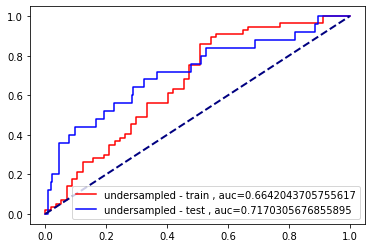

In [210]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [211]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[-0.00011343  0.0012627 ]] [-1.61876772]


In [213]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.69      0.57      0.63       533
           1       0.63      0.75      0.69       533

    accuracy                           0.66      1066
   macro avg       0.66      0.66      0.66      1066
weighted avg       0.66      0.66      0.66      1066

test set
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       229
           1       0.18      0.68      0.28        25

    accuracy                           0.66       254
   macro avg       0.56      0.67      0.53       254
weighted avg       0.87      0.66      0.73       254



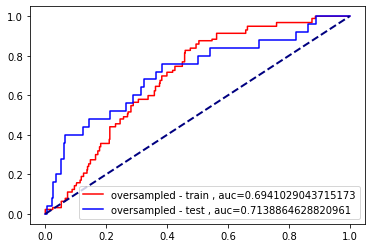

In [214]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [184]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[0.00566324 0.00348379]] [-1.47912294]


In [93]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.68      0.61      0.65      4389
           1       0.65      0.72      0.68      4389

    accuracy                           0.66      8778
   macro avg       0.67      0.66      0.66      8778
weighted avg       0.67      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1848
           1       0.19      0.73      0.30       218

    accuracy                           0.63      2066
   macro avg       0.57      0.68      0.52      2066
weighted avg       0.87      0.63      0.70      2066



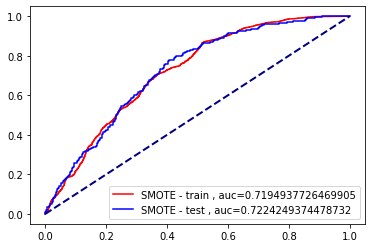

In [94]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [95]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[0.00353505 0.00209055]] [-2.97602996]


## **XGBoost**

In [185]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.748006
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.735897
[2]	validation_0-auc:0.735897
[3]	validation_0-auc:0.735897
[4]	validation_0-auc:0.736467
[5]	validation_0-auc:0.759259
[6]	validation_0-auc:0.759259
[7]	validation_0-auc:0.751852
[8]	validation_0-auc:0.752422
[9]	validation_0-auc:0.749573
[10]	validation_0-auc:0.749573
Stopping. Best iteration:
[5]	validation_0-auc:0.759259

training set
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        28
           1       0.79      0.96      0.87        28

    accuracy                           0.86        56
   macro avg       0.87      0.86      0.86        56
weighted avg       0.87      0.86      0.86        56

test set
              precision    recall  f1-score   support

           0       0.98      0.59      0.74       234
           1       0.11      0.80      0.20        15

    acc

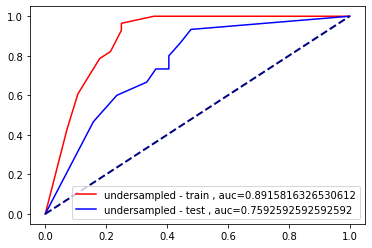

In [186]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

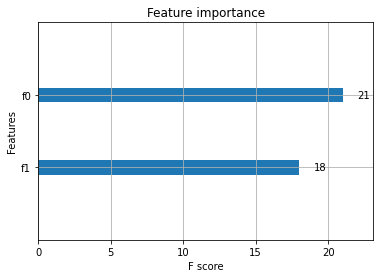

In [187]:
xgb.plot_importance(xgb_model_under)

In [188]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.787037
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.787037
[2]	validation_0-auc:0.792593
[3]	validation_0-auc:0.770228
[4]	validation_0-auc:0.765385
[5]	validation_0-auc:0.775071
[6]	validation_0-auc:0.778205
[7]	validation_0-auc:0.778205
Stopping. Best iteration:
[2]	validation_0-auc:0.792593

training set
              precision    recall  f1-score   support

           0       0.93      0.69      0.80       550
           1       0.76      0.95      0.84       550

    accuracy                           0.82      1100
   macro avg       0.84      0.82      0.82      1100
weighted avg       0.84      0.82      0.82      1100

test set
              precision    recall  f1-score   support

           0       0.98      0.66      0.79       234
           1       0.13      0.80      0.23        15

    accuracy                           0.67       249
   macro avg       0.56      0.73      0.51  

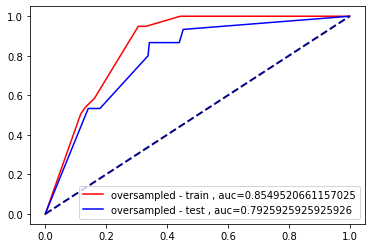

In [189]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

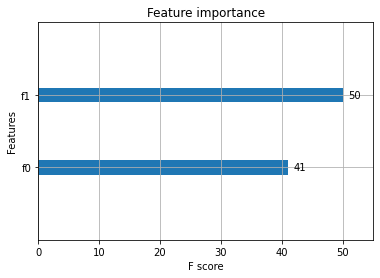

In [101]:
xgb.plot_importance(xgb_model_over)

In [102]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.710164
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.712932
[2]	validation_0-auc:0.711748
[3]	validation_0-auc:0.722312
[4]	validation_0-auc:0.724391
[5]	validation_0-auc:0.727393
[6]	validation_0-auc:0.728292
[7]	validation_0-auc:0.727832
[8]	validation_0-auc:0.729046
[9]	validation_0-auc:0.729419
[10]	validation_0-auc:0.729344
[11]	validation_0-auc:0.727919
[12]	validation_0-auc:0.72875
[13]	validation_0-auc:0.728701
[14]	validation_0-auc:0.729777
[15]	validation_0-auc:0.730676
[16]	validation_0-auc:0.729857
[17]	validation_0-auc:0.731547
[18]	validation_0-auc:0.732292
[19]	validation_0-auc:0.732792
[20]	validation_0-auc:0.730907
[21]	validation_0-auc:0.731447
[22]	validation_0-auc:0.731588
[23]	validation_0-auc:0.730677
[24]	validation_0-auc:0.731223
Stopping. Best iteration:
[19]	validation_0-auc:0.732792

training set
              precision    recall  f1-score   support

           0       0.77  

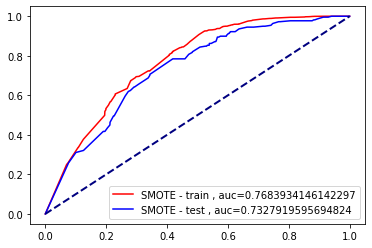

In [103]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

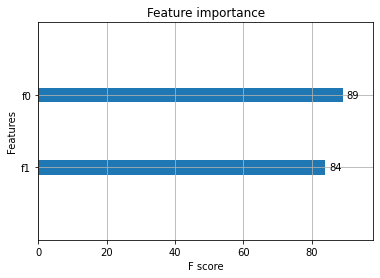

In [104]:
xgb.plot_importance(xgb_model_SMOTE)

In [105]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.614454
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.720107
[2]	validation_0-auc:0.719745
[3]	validation_0-auc:0.720985
[4]	validation_0-auc:0.72975
[5]	validation_0-auc:0.725265
[6]	validation_0-auc:0.727804
[7]	validation_0-auc:0.72326
[8]	validation_0-auc:0.724477
[9]	validation_0-auc:0.721706
Stopping. Best iteration:
[4]	validation_0-auc:0.72975

training set
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      4389
           1       0.67      0.75      0.71      4389

    accuracy                           0.69      8778
   macro avg       0.70      0.69      0.69      8778
weighted avg       0.70      0.69      0.69      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.64      0.76      1848
           1       0.19      0.72      0.30       218

    accuracy                 

# Random Forest


In [190]:
%matplotlib inline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
print('Random forest - undersampled')
alpha=[10,50,100,500,1000,2000,3000]
predicted_y = []
expected_y = []
cv_auc_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_undersampled,y_undersampled)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_undersampled, y_undersampled)
    predict_y = sig_clf.predict_proba(X_undersampled)
    cv_auc_array.append(roc_auc_score(y_undersampled, predict_y[:,1]))

for i in range(len(cv_auc_array)):
    print ('AUC for number of estimators = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_undersampled,y_undersampled)
sig_clfran = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clfran.fit(X_undersampled, y_undersampled)
predictions = sig_clfran.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = sig_clfran.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Random forest - undersampled
AUC for number of estimators =  10 is 1.0
AUC for number of estimators =  50 is 1.0
AUC for number of estimators =  100 is 1.0
AUC for number of estimators =  500 is 1.0
AUC for number of estimators =  1000 is 1.0
AUC for number of estimators =  2000 is 1.0
AUC for number of estimators =  3000 is 1.0
training set
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.93      1.00      0.97        28

    accuracy                           0.96        56
   macro avg       0.97      0.96      0.96        56
weighted avg       0.97      0.96      0.96        56

test set
              precision    recall  f1-score   support

           0       0.97      0.61      0.75       234
           1       0.11      0.73      0.19        15

    accuracy                           0.61       249
   macro avg       0.54      0.67      0.47       249
weighted avg       0.92      0.61      0.71     

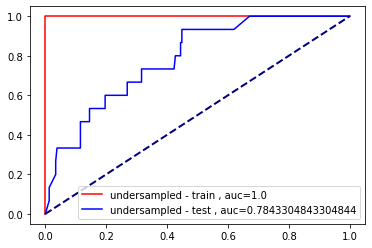

In [192]:
y_score_train = sig_clfran.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = sig_clfran.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [108]:
%matplotlib inline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
print('Random forest - oversampled')
alpha=[10,50,100,500,1000,2000,3000]
predicted_y = []
expected_y = []
cv_auc_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_oversampled,y_oversampled)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_oversampled, y_oversampled)
    predict_y = sig_clf.predict_proba(X_oversampled)
    cv_auc_array.append(roc_auc_score(y_oversampled, predict_y[:,1]))

for i in range(len(cv_auc_array)):
    print ('AUC for number of estimators = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_oversampled,y_oversampled)
sig_clfran = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clfran.fit(X_oversampled, y_oversampled)
predictions = sig_clfran.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = sig_clfran.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Random forest - oversampled
AUC for number of estimators =  10 is 0.9999665426330174
AUC for number of estimators =  50 is 0.9999695535364852
AUC for number of estimators =  100 is 0.9999724087035667
AUC for number of estimators =  500 is 0.9999727201763393
AUC for number of estimators =  1000 is 0.9999734469461419
AUC for number of estimators =  2000 is 0.9999734988582707
AUC for number of estimators =  3000 is 0.9999732392976268
training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4389
           1       1.00      1.00      1.00      4389

    accuracy                           1.00      8778
   macro avg       1.00      1.00      1.00      8778
weighted avg       1.00      1.00      1.00      8778

test set
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1848
           1       0.17      0.03      0.05       218

    accuracy                           0.88      206

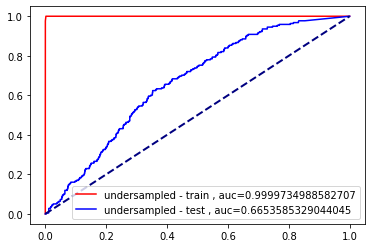

In [109]:
y_score_train = sig_clfran.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = sig_clfran.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [110]:
%matplotlib inline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
print('Random forest - smote')
alpha=[10,50,100,500,1000,2000,3000]
predicted_y = []
expected_y = []
cv_auc_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_SMOTE,y_SMOTE)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_SMOTE, y_SMOTE)
    predict_y = sig_clf.predict_proba(X_SMOTE)
    cv_auc_array.append(roc_auc_score(y_SMOTE, predict_y[:,1]))

for i in range(len(cv_auc_array)):
    print ('AUC for number of estimators = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_SMOTE,y_SMOTE)
sig_clfran = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clfran.fit(X_SMOTE, y_SMOTE)
predictions = sig_clfran.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = sig_clfran.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Random forest - smote
AUC for number of estimators =  10 is 0.9996285946748229
AUC for number of estimators =  50 is 0.9999601574411806
AUC for number of estimators =  100 is 0.9999725125278242
AUC for number of estimators =  500 is 0.9999797283137213
AUC for number of estimators =  1000 is 0.9999786900711461
AUC for number of estimators =  2000 is 0.9999806108199101
AUC for number of estimators =  3000 is 0.9999817528867426
training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4389
           1       1.00      1.00      1.00      4389

    accuracy                           1.00      8778
   macro avg       1.00      1.00      1.00      8778
weighted avg       1.00      1.00      1.00      8778

test set
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1848
           1       0.17      0.28      0.21       218

    accuracy                           0.78      2066
   m

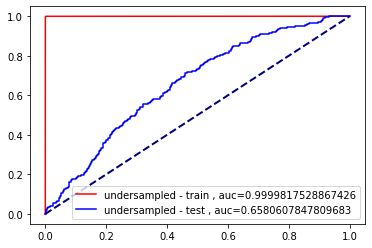

In [111]:
y_score_train = sig_clfran.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = sig_clfran.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [ ]:
#https://datascience.stackexchange.com/questions/62687/customer-segmentation-with-unbalanced-data
#https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
#https://medium.com/analytics-vidhya/rfm-analysis-for-customer-segmentation-with-python-i-bb9ebadd0a96
#https://medium.com/merino-services-analytics-blog/customer-segmentation-with-rfm-analysis-part-2-eadf3b220540
